# Notebook: fine-tune SAM (segment anything) on COCO 2017 dataset

In this notebook, we'll fine-tune [SAM](https://huggingface.co/docs/transformers/main/en/model_doc/sam) on the COCO 2017 dataset. 

# SAM 
The Segment Anything Model (SAM) is able to generate high quality object masks given a prompt, such as poitns or boxes. 
The SAM module is made up of 3 modules:
1. The VisionEncoder: A Vision Transformer based image encoder. it computes the image embeddings using attention on patches of the image. 
2. The PromptEncoder: Generates embeddings for poitns and bounding boxes. 
3. The MaskDecoder: A two ways transformer which performs cross attention between the image embedding and the poitn embeddinds and vice versa. 
4. The Neck: Predicts the final segmentation mask given the output of the MaskDecoder.


## Set-up environment

In [ ]:
! pip install peft transformers accelerate



   ---------------------------------------- 0/2 [accelerate]
   ---------------------------------------- 0/2 [accelerate]
   ---------------------------------------- 0/2 [accelerate]
   ---------------------------------------- 0/2 [accelerate]
   ---------------------------------------- 0/2 [accelerate]
   ---------------------------------------- 0/2 [accelerate]
   ---------------------------------------- 0/2 [accelerate]
   ---------------------------------------- 0/2 [accelerate]
   ---------------------------------------- 0/2 [accelerate]
   ---------------------------------------- 0/2 [accelerate]
   -------------------- ------------------- 1/2 [peft]
   -------------------- ------------------- 1/2 [peft]
   -------------------- ------------------- 1/2 [peft]
   -------------------- ------------------- 1/2 [peft]
   -------------------- ------------------- 1/2 [peft]
   -------------------- ------------------- 1/2 [peft]
   -------------------- ------------------- 1/2 [peft]
   -

: 

In [2]:
! pip install -q git+https://github.com/huggingface/transformers.git

In [3]:
! pip install -q datasets

We also install the [Monai](https://github.com/Project-MONAI/MONAI) repository as we'll use a custom loss function from it.

In [1]:
! pip install -q monai

In [3]:
! pip install torch torchvision 


^C


ERROR: Could not install packages due to an OSError: [Errno 28] No space left on device



Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached https://download.pytorch.org/whl/mpmath-1.3.0-py3-none-any.whl (536 kB)
   ---------------------------------------- 0.0/2.9 GB ? eta -:--:--
   ---------------------------------------- 0.0/2.9 GB 20.5 MB/s eta 0:02:23
   ---------------------------------------- 0.0/2.9 GB 16.0 MB/s eta 0:03:02
   ---------------------------------------- 0.0/2.9 GB 12.6 MB/s eta 0:03:51
   ---------------------------------------- 0.0/2.9 GB 13.7 MB/s eta 0:03:31
   ---------------------------------------- 0.0/2.9 GB 13.8 MB/s eta 0:03:30
   ---------------------------------------- 0.0/2.9 GB 14.1 MB/s eta 0:03:25
   ---------------------------------------- 0.0/2.9 GB 13.6 MB/s eta 0:03:33
   ----------------------------

In [ ]:
! pip install pycocotools 

## Data preparation. 

We use SamProcessor to prepare the data for SAM. 
SamProcessor is a class provided by the Hugging Face transformers library.
The processor is an object that combines multiple preprocessing steps necessary to transform raw data (like images and prompts) into the format that the SAM model expects as input. Its logic:
1. Take a raw image and optionally its prompts (poitns, or boxes) in the coordinates of the original image.
2. Use an inner SamImageProcessor to process the image (resizing, normalization).
3. If the promtp are provided, transforms their coordinates to align them with the processed image. This is essential because the models expects the prompts to be the same coordiantes space of the image it receives. 
4. Converts all the outputs in tensors.
5. Returns a dictionary containing all the inputs ready to be sent to the model. 





In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")


c:\Users\Aurora Pia Ghiardell\.conda\envs\SegVision\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
c:\Users\Aurora Pia Ghiardell\.conda\envs\SegVision\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In this part of the project we show how to finetune the model SAM with respect of the specif class Person in the dataset COCO 2017. 
Fine tuning a model like SAM is very time consuming (in particular without a proper GPU) because the model is very big. For this reason (hardware constraint) we just show an example with respect to 1 class, but you can use the same procedure even for multi class problems. 

We load 2000 examples from the dataset COCO 2017, and we sample 1900 images with the category 1 and 100 without the category 1. 
 

In [2]:
from utils.dataloader import dataloader, COCOSegmentationDataset
import torch
from torchvision import transforms
from torch.utils.data import Subset
import random
from tqdm import tqdm
COCO_ROOT_DIR = "data\\train2017\\"
split="train",
year="2017",
resize_transform = transforms.Compose([
    transforms.Resize((1024, 1024)),  
    transforms.ToTensor(),        
])

dataset = COCOSegmentationDataset(
    root_dir=COCO_ROOT_DIR,
    split=split,
    year=year,
    processor=processor,
    resize=resize_transform,
)

class_id_to_filter = 1
indices_with_class_1 = []
indices_without_class_1 = []

for idx in tqdm(range(10)):
    sample = dataset[idx]
    ground_truth_mask = sample["ground_truth_mask"]  
    
    if (ground_truth_mask == class_id_to_filter).any():
        indices_with_class_1.append(idx)
    else:
        indices_without_class_1.append(idx)

random.seed(42) 
selected_indices_with_class_1 = random.sample(indices_with_class_1, min(1, len(indices_with_class_1)))
# selected_indices_without_class_1 = random.sample(indices_without_class_1, min(100, len(indices_without_class_1)))
final_indices = selected_indices_with_class_1 
final_dataset = Subset(dataset, final_indices)

print(f"Number of images with class 1 (Person): {len(selected_indices_with_class_1)}")
final_dataloader = dataloader(
    dataset=final_dataset,
    split="train",
    year="2017",
    batch_size=1,
    shuffle=True)



PyTorch version: 2.5.1
Torchvision version: 0.20.1
Annotation file path: data\train2017\annotations\instances_train2017.json
loading annotations into memory...


Done (t=17.77s)
creating index...
index created!


100%|██████████| 10/10 [00:01<00:00,  9.74it/s]

Number of images with class 1 (Person): 1
DataLoader created for train2017. Number of batches: 1


In [3]:
dataset = None

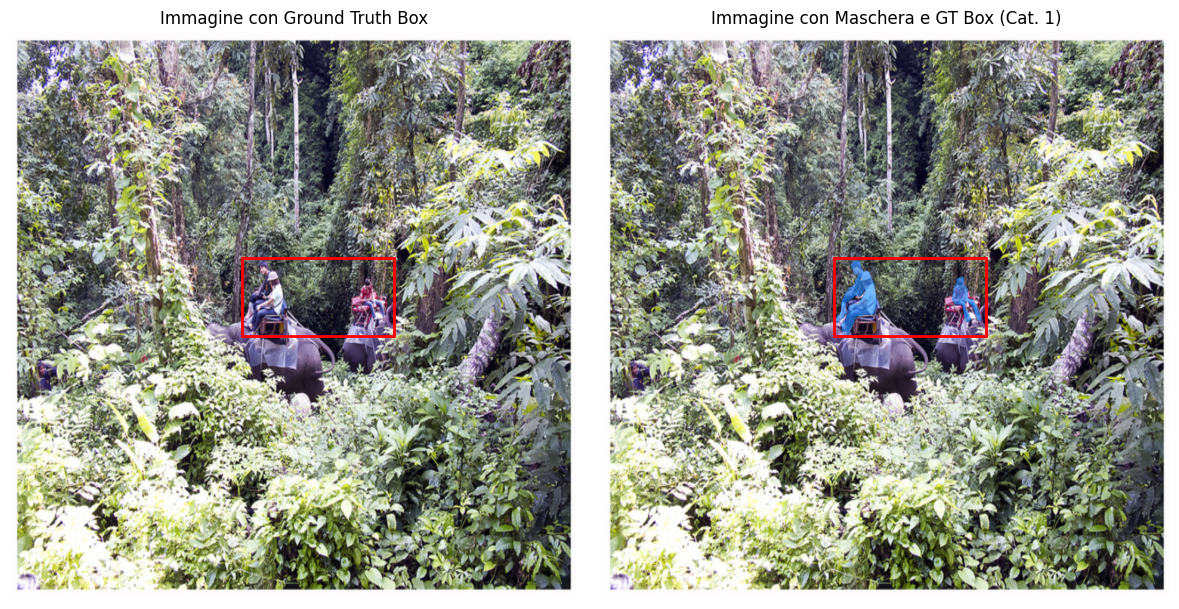

IndexError: list index out of range

In [5]:
from utils.visualization import show_image_with_mask


show_image_with_mask(final_dataset, 0, True, processor)
show_image_with_mask(final_dataset, 1, True, processor)


In [ ]:
from collections import Counter
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from pycocotools.coco import COCO

class_distribution = Counter()
for i in tqdm(range(len(final_dataset))):
    sample = final_dataset[i]
    mask = sample["ground_truth_mask"]  
    if isinstance(mask, torch.Tensor):
        mask = mask.squeeze()  
    unique_classes = torch.unique(mask)
    class_distribution.update(unique_classes.tolist())




100%|██████████| 500/500 [00:57<00:00,  8.73it/s]


Distribuzione delle classi (in ordine decrescente):
Classe 0: 500 images
Classe 1: 500 images
Classe 62: 74 images
Classe 3: 67 images
Classe 31: 50 images
Classe 67: 49 images
Classe 37: 40 images
Classe 47: 40 images
Classe 43: 34 images
Classe 27: 31 images
Classe 15: 31 images
Classe 28: 31 images
Classe 8: 31 images
Classe 44: 31 images
Classe 42: 29 images
Classe 41: 27 images
Classe 32: 26 images
Classe 77: 24 images
Classe 84: 24 images
Classe 35: 24 images
Classe 51: 24 images
Classe 19: 23 images
Classe 4: 22 images
Classe 2: 22 images
Classe 85: 21 images
Classe 6: 20 images
Classe 38: 19 images
Classe 34: 18 images
Classe 18: 18 images
Classe 39: 18 images
Classe 40: 18 images
Classe 64: 17 images
Classe 63: 17 images
Classe 79: 15 images
Classe 46: 15 images
Classe 49: 15 images
Classe 73: 15 images
Classe 75: 15 images
Classe 61: 14 images
Classe 50: 14 images
Classe 36: 13 images
Classe 10: 13 images
Classe 9: 12 images
Classe 33: 12 images
Classe 72: 12 images
Classe 5:

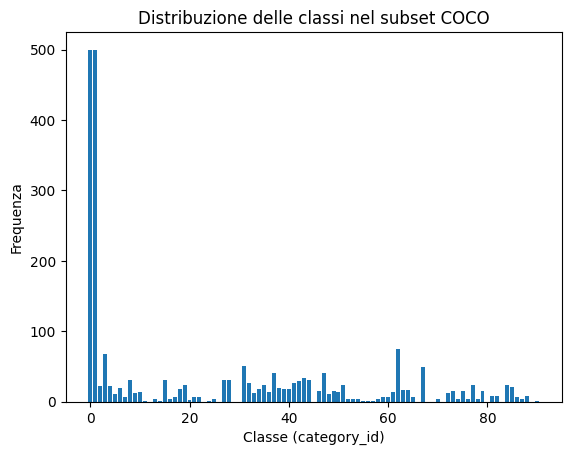

In [7]:
print("Distribuzione delle classi (in ordine decrescente):")
for cls_id, count in class_distribution.most_common():
    print(f"Classe {int(cls_id)}: {count} images")

plt.bar(class_distribution.keys(), class_distribution.values())
plt.xlabel("Classe (category_id)")
plt.ylabel("Frequenza")
plt.title("Distribuzione delle classi nel subset COCO")
plt.show()

## Create PyTorch DataLoader

Next we define a PyTorch Dataloader, which allows us to get batches from the dataset.



In [9]:
example = dataset
for i in range(5):
  for k,v in example[i].items():
    print(k,v.shape)

batch = next(iter(final_dataloader))
for k,v in batch.items():
  print(k,v.shape)

example = dataset[0]
print("Example image shape:", torch.unique(example['ground_truth_mask']))

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask torch.Size([1, 1, 480, 640])
pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask torch.Size([1, 1, 426, 640])
pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask torch.Size([1, 1, 428, 640])
pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask torch.Size([1, 1, 425, 640])
pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask torch.Size([1, 1, 640, 481])
pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.

# Load the Model
To fine tune the model we decided to fine tune just the decoder module of the model, because is the part responsable for generating the final segmentation masks conditioned on the prompts and the encoder's features. 
Furthermore, finetuning the complete model is very expensive in terms of resource (The full model contains 93735472 parameters)
The advantages of this strategy:
- Reduced computational cost: Only a small part of the model is updated (4.33%).
- The encoder's weights remain fixed leveraging their generalization power and reducing the risk of overfitting to a small custom dataset. 
- Efficient adaptation: The decoder can quickly adapt to new segmentation tasks or classes using the strong features from the encoder. 

We freeze the parameters of the vision encoder and of the prompt encoder.


In [4]:
from models.SAM import SAM
sam = SAM(processor=processor)
model = sam.model
sam.trainable_parameters()



Trainable parameters: 4058340 / 93735472 (4.33%)


(4058340, 93735472)

# CREATE EMBEDDINGS
In order to shorten the training, we compute the embeddings in advance, by passing the images through the vision encoder. This significantly speeds up the training process, given that just to perform a forward pass through the encoder requires 10 seconds. By computing the embeddings in adavnce we are able to fine tune the decoder without doing for each observation at every epoch the forward pass through the encoder.

As you can see, computing the embeddings required a bit more than 6 hours. 

In [7]:
from tqdm import tqdm
import torch
import os

model.eval()

image_embeddings_dataset = []
image_encoder = model.vision_encoder

with torch.no_grad():
    for batch in tqdm(final_dataloader):
        pixel_values = batch["pixel_values"]
        image_embeddings = image_encoder(pixel_values)

        image_embeddings_dataset.append({
            "embedding": image_embeddings,  # salva su CPU
            "input_boxes": batch["input_boxes"],  # tensor (B, 4)
            "ground_truth_mask": batch["ground_truth_mask"]  # tensor (B, H, W)
        })

torch.save(image_embeddings_dataset, "precomputed_embeddings.pt")
print("✅ Saved all embeddings to precomputed_embeddings.pt")


  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [1:35:32<00:00, 11.46s/it]


✅ Saved all embeddings to precomputed_embeddings.pt


In [8]:
image_embeddings_dataset = None

In [ ]:
# #Divide the dataset in chunks
# chunk_size = 100  # Numero di elementi per file
# for i in range(0, len(image_embeddings_dataset), chunk_size):
#     chunk = image_embeddings_dataset[i:i + chunk_size]
#     torch.save(chunk, f"precomputed_embeddings_part_{i // chunk_size}.pt")
#     print(f"✅ Saved chunk {i // chunk_size}")

## Train the model

In [9]:
from tqdm import tqdm
import torch
import os


embeddings_file_path = "precomputed_embeddings.pt"

precomputed_embeddings = torch.load(embeddings_file_path)

print(f"Loaded {len(precomputed_embeddings)} embeddings.")

first_embedding = precomputed_embeddings[0]
print("Keys in the first embedding:", first_embedding.keys())
print("Shape of the embedding tensor:", first_embedding["embedding"])
print("Shape of the input boxes:", first_embedding["input_boxes"].shape)
print("Shape of the ground truth mask:", first_embedding["ground_truth_mask"].shape)

C:\Users\Aurora Pia Ghiardell\AppData\Local\Temp\ipykernel_10428\2072934379.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  precomputed_embeddings = torch.load(embedding

Loaded 500 embeddings.
Keys in the first embedding: dict_keys(['embedding', 'input_boxes', 'ground_truth_mask'])
Shape of the embedding tensor: SamVisionEncoderOutput(image_embeds=None, last_hidden_state=tensor([[[[ 0.0138,  0.0255,  0.0306,  ..., -0.0246, -0.0256, -0.0330],
          [-0.0099,  0.0065,  0.0136,  ..., -0.0260, -0.0336, -0.0472],
          [-0.0077, -0.0178, -0.0069,  ..., -0.0253, -0.0352, -0.0461],
          ...,
          [-0.0252, -0.0168, -0.0200,  ...,  0.0155,  0.0099, -0.0064],
          [-0.0147, -0.0009, -0.0218,  ...,  0.0175,  0.0063, -0.0036],
          [-0.0204, -0.0204, -0.0387,  ..., -0.0104, -0.0050, -0.0213]],

         [[-0.1081, -0.1661, -0.1451,  ..., -0.0953, -0.1236, -0.0789],
          [-0.1013, -0.1135,  0.0967,  ..., -0.0256, -0.0556, -0.1012],
          [-0.1276, -0.1274, -0.0431,  ..., -0.1298, -0.1683, -0.1471],
          ...,
          [-0.0694, -0.1418, -0.1193,  ..., -0.1044, -0.1214, -0.0843],
          [-0.0119, -0.1596, -0.0905,  ..., 

In [13]:
from torch.optim import AdamW
from monai.losses import DiceCELoss
from torch.optim.lr_scheduler import StepLR

optimizer = AdamW(model.parameters(), lr=5e-4)  # learning rate aumentato

seg_loss = DiceCELoss(
    sigmoid=True, 
    to_onehot_y=False,
    
    squared_pred=False,
    reduction='mean'
)

scheduler = StepLR(optimizer, step_size=30, gamma=0.5)

Performed the training for 100 epochs took approximately 10 hours. To load the embeddings and to use them to fine tune the decoder we use the class EmbeddingDataset. In the class Embedding dataset, there is the possibility to choose the target class of the fine tuning (in our experiment is 1).


In [ ]:
from tqdm import tqdm
from statistics import mean
import torch
import random
import numpy as np
from torch.utils.data import random_split, DataLoader, Dataset
import torch.nn.functional as F
from utils.dataloader import EmbeddingsDataset
from utils.metrics import binary_dice




def resize_mask(batch, outputs, processor, labels = False):
    original_image_sizes = [(1024, 1024)]  # lista di tuple
    reshaped_input_sizes = [(1024, 1024)]


    upscaled_masks_logits = processor.post_process_masks(
        outputs.pred_masks.cpu(), # Passa i logit a bassa risoluzione (spostati su CPU se necessario)
        original_image_sizes,   # Dimensioni originali dell'immagine prima del processing di SAM
        reshaped_input_sizes,   # Dimensioni dell'immagine dopo il resize di SAM (prima del padding)
        binarize=False          # Vogliamo i logit, non maschere binarizzate direttamente qui
    )
    if isinstance(upscaled_masks_logits, list):
        upscaled_masks_logits = torch.stack(upscaled_masks_logits)  # shape: (1, 1, H, W)
    upscaled_masks_logits = upscaled_masks_logits.squeeze(0)  
    
    pred_mask_probs = torch.sigmoid(upscaled_masks_logits.squeeze(1))
    if labels:
        pred_mask_bin = (pred_mask_probs > 0.5).float()  
        return pred_mask_bin# Binarizza le probabilità
    else: 
        return pred_mask_probs  # Restituisci le probabilità  





dataset = EmbeddingsDataset(precomputed_embeddings, target_class_index=1)  # Modifica qui per la classe desiderata


seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)


train_size = int(0.8 * len(dataset))  # 80% training
val_size = len(dataset) - train_size  # 20% validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print(train_dataset[1]['ground_truth_mask'].shape)
      
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# checkpoint_path = "model_epoch_75.pth"
# state_dict = torch.load(checkpoint_path, map_location="cpu")  # or "cuda" if you want to load on GPU
# model.load_state_dict(state_dict)
# print(f"Model loaded from {checkpoint_path}")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
num_epochs = 15
model.train()
with open("training_SAM_results.txt", "w") as results_file:
    for epoch in range(0, num_epochs):
        model.train()
        train_losses = []
        Dice_trains = []
        for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1} - Training"):
            embeddings = batch["embedding"].squeeze(1).to(device)
            input_boxes = batch["input_boxes"].squeeze(1).to(device)
            ground_truth_masks = batch["ground_truth_mask"].float().to(device)
            # print("GT shape:", batch["ground_truth_mask"].shape)
            # print("Unique labels:", torch.unique(batch["ground_truth_mask"]))

            outputs = model(
                input_boxes=input_boxes,
                multimask_output=False,
                image_embeddings=embeddings,
            )
            predicted_masks = resize_mask(batch, outputs, processor)
            loss = seg_loss(predicted_masks, ground_truth_masks.squeeze(0))
            # print(np.unique(ground_truth_masks))
            # print("Loss:", loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            labels = resize_mask(batch, outputs, processor, labels=True)
            train_losses.append(loss.item())
            dice_train = binary_dice(labels, ground_truth_masks)
            Dice_trains.append(dice_train)

        scheduler.step()
        

        # model.eval()
        val_losses = []
        Dice_vals = []
        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc=f"Epoch {epoch + 1} - Validation"):
                embeddings = batch["embedding"].squeeze(1).to(device)
                input_boxes = batch["input_boxes"].squeeze(1).to(device)
                ground_truth_masks = batch["ground_truth_mask"].float().to(device)

                outputs = model(
                    input_boxes=input_boxes,
                    multimask_output=False,
                    image_embeddings=embeddings,
                )

                predicted_masks = resize_mask(batch, outputs, processor)    

                loss = seg_loss(predicted_masks, ground_truth_masks.squeeze(0))
                val_losses.append(loss.item())
                labels = resize_mask(batch, outputs, processor, labels=True)
                dice_val = binary_dice(labels, ground_truth_masks)
                Dice_vals.append(dice_val)

        avg_train_loss = sum(train_losses) / len(train_losses)
        avg_val_loss = sum(val_losses) / len(val_losses)
        avg_dice_train = sum(Dice_trains) / len(Dice_trains)
        avg_dice_val = sum(Dice_vals) / len(Dice_vals)

        results_file.write(f"Epoch {epoch + 1}\n")
        results_file.write(f"  Training Loss: {avg_train_loss:.4f}\n")
        results_file.write(f"  Validation Loss: {avg_val_loss:.4f}\n")
        results_file.write(f"  Training Dice: {avg_dice_train:.4f}\n")
        results_file.write(f"  Validation Dice: {avg_dice_val:.4f}\n")
        results_file.write(f"  Learning Rate: {scheduler.get_last_lr()[0]:.6f}\n")

        results_file.write("\n")
        results_file.flush()  # Forza la scrittura su disco

        print(f"Epoch {epoch + 1} - Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Dice Train: {avg_dice_train:.4f}, Dice Val: {avg_dice_val:.4f}, Learning Rate: {scheduler.get_last_lr()[0]:.6f}")

        if (epoch + 1) % 10 == 0:
            model_save_path = f"model_epoch_{epoch + 1}.pth"
            torch.save(model.state_dict(), model_save_path)
            print(f"✅ Model saved to {model_save_path}")
    
    final_model_save_path = "final_model.pth"
    torch.save(model.state_dict(), final_model_save_path)
    print(f"✅ Final model saved to {final_model_save_path}")



    

Trainable parameters: 4058340 / 93735472 (4.33%)
torch.Size([1, 1024, 1024])


Epoch 1 - Validation: 100%|██████████| 100/100 [00:09<00:00, 10.61it/s]


Epoch 1 - Training Loss: 1039.9893, Validation Loss: 947.9722, Dice Train: 0.9571, Dice Val: 0.9425, Learning Rate: 0.000500


Epoch 2 - Validation: 100%|██████████| 100/100 [00:10<00:00,  9.90it/s]


Epoch 2 - Training Loss: 1042.2707, Validation Loss: 947.6773, Dice Train: 0.9261, Dice Val: 0.9534, Learning Rate: 0.000500


Epoch 3 - Validation: 100%|██████████| 100/100 [00:10<00:00,  9.83it/s]


Epoch 3 - Training Loss: 1039.0141, Validation Loss: 948.6464, Dice Train: 0.9636, Dice Val: 0.9696, Learning Rate: 0.000500


Epoch 4 - Validation: 100%|██████████| 100/100 [00:09<00:00, 10.49it/s]


Epoch 4 - Training Loss: 1039.4195, Validation Loss: 947.6860, Dice Train: 0.9601, Dice Val: 0.9535, Learning Rate: 0.000500


Epoch 5 - Validation: 100%|██████████| 100/100 [00:10<00:00,  9.26it/s]


Epoch 5 - Training Loss: 1038.8555, Validation Loss: 949.5454, Dice Train: 0.9642, Dice Val: 0.9412, Learning Rate: 0.000500


Epoch 6 - Validation: 100%|██████████| 100/100 [00:14<00:00,  7.12it/s]


Epoch 6 - Training Loss: 1038.6430, Validation Loss: 950.2532, Dice Train: 0.9629, Dice Val: 0.9244, Learning Rate: 0.000500


Epoch 7 - Validation: 100%|██████████| 100/100 [00:11<00:00,  8.68it/s]


Epoch 7 - Training Loss: 1038.2925, Validation Loss: 948.3571, Dice Train: 0.9670, Dice Val: 0.9724, Learning Rate: 0.000500


Epoch 8 - Validation: 100%|██████████| 100/100 [00:12<00:00,  8.09it/s]


Epoch 8 - Training Loss: 1039.1387, Validation Loss: 948.2816, Dice Train: 0.9629, Dice Val: 0.9703, Learning Rate: 0.000500


Epoch 9 - Validation: 100%|██████████| 100/100 [00:10<00:00,  9.40it/s]


Epoch 9 - Training Loss: 1038.2659, Validation Loss: 947.9086, Dice Train: 0.9620, Dice Val: 0.9373, Learning Rate: 0.000500


Epoch 10 - Validation: 100%|██████████| 100/100 [00:11<00:00,  8.38it/s]


Epoch 10 - Training Loss: 1038.1265, Validation Loss: 948.8882, Dice Train: 0.9623, Dice Val: 0.9432, Learning Rate: 0.000500
✅ Model saved to model_epoch_10.pth


Epoch 11 - Validation: 100%|██████████| 100/100 [00:12<00:00,  8.21it/s]


Epoch 11 - Training Loss: 1037.7738, Validation Loss: 948.0832, Dice Train: 0.9663, Dice Val: 0.9548, Learning Rate: 0.000500


Epoch 12 - Validation: 100%|██████████| 100/100 [00:11<00:00,  8.62it/s]


Epoch 12 - Training Loss: 1037.5651, Validation Loss: 948.2200, Dice Train: 0.9669, Dice Val: 0.9493, Learning Rate: 0.000500


Epoch 13 - Validation: 100%|██████████| 100/100 [00:11<00:00,  9.02it/s]


Epoch 13 - Training Loss: 1037.0141, Validation Loss: 949.6896, Dice Train: 0.9698, Dice Val: 0.9245, Learning Rate: 0.000500


Epoch 14 - Validation: 100%|██████████| 100/100 [00:12<00:00,  8.29it/s]


Epoch 14 - Training Loss: 1037.1237, Validation Loss: 948.5329, Dice Train: 0.9695, Dice Val: 0.9604, Learning Rate: 0.000500


Epoch 15 - Validation: 100%|██████████| 100/100 [00:12<00:00,  8.23it/s]


Epoch 15 - Training Loss: 1037.1266, Validation Loss: 948.3375, Dice Train: 0.9688, Dice Val: 0.9585, Learning Rate: 0.000500
✅ Final model saved to final_model.pth


## Inference

Important note here: as we used the Dice loss with `sigmoid=True`, we need to make sure to appropriately apply a sigmoid activation function to the predicted masks. Hence we won't use the processor's `post_process_masks` method here.

In [5]:


from utils.visualization import show_mask


# def show_mask(mask_tensor, ax, category=1, random_color=False):
#     """
#     Mostra la maschera per una specifica categoria, con overlay sulla figura.
#     Args:
#         mask_tensor (torch.Tensor): Maschera di input (potrebbe essere 4D).
#         ax (matplotlib.axes.Axes): Asse su cui visualizzare la maschera.
#         category (int): Categoria da visualizzare.
#         random_color (bool): Se True, usa colore casuale.
#     """
#     mask_np = mask_tensor.cpu().numpy()  # Converti in numpy
#     if mask_np.ndim > 2:
#         mask_np = np.squeeze(mask_np) 

#     if mask_np.ndim != 2:
#         raise ValueError(f"Mask should be 2D after squeezing, but got shape {mask_np.shape}")

#     binary_mask_np = (mask_np == category).astype(np.uint8)
#     if random_color:
#         color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)  
#     else:
#         color = np.array([30/255, 144/255, 255/255, 0.6])  

#     pil_mask_image = Image.fromarray(binary_mask_np * 255)
    
#     # pil_mask_resized = pil_mask_image.resize((1024, 1024), Image.NEAREST)
#     binary_mask_resized_float = np.array(pil_mask_image) / 255.0 
#     mask_image_colored = binary_mask_resized_float[..., None] * color.reshape(1, 1, -1)
#     ax.imshow(mask_image_colored)

# def resize_mask(batch, output, processor):
    
#     original_image_sizes = batch["original_sizes"]
#     reshaped_input_sizes = batch["reshaped_input_sizes"]

#     upscaled_masks_logits = processor.post_process_masks(
#         outputs.pred_masks.cpu(), # Passa i logit a bassa risoluzione (spostati su CPU se necessario)
#         original_image_sizes,   # Dimensioni originali dell'immagine prima del processing di SAM
#         reshaped_input_sizes,   # Dimensioni dell'immagine dopo il resize di SAM (prima del padding)
#         binarize=False          # Vogliamo i logit, non maschere binarizzate direttamente qui
#     )
#     if isinstance(upscaled_masks_logits, list):
#         upscaled_masks_logits = torch.stack(upscaled_masks_logits)  # shape: (1, 1, H, W)
#     upscaled_masks_logits = upscaled_masks_logits.squeeze(0)  
#     pred_mask_probs = torch.sigmoid(upscaled_masks_logits.squeeze(1)) 
#     pred_mask_bin = (pred_mask_probs > 0.5).squeeze(0) 
#     return pred_mask_bin    

for batch in final_dataloader:
    sam.predict_SAM(
        batch,
        image_embeddings=None,
        visualize_prediction=True,
        checkpoint_dir='final_model.pth',
    )

    # # Utilizza direttamente i tensori dal batch mantenendo la dimensione del batch
    # model_input_boxes = batch["input_boxes"] # Forma attesa (batch_size, num_boxes, 4), es. (1,1,4)
    # model_pixel_values = batch["pixel_values"] # Forma attesa (batch_size, C, H, W), es. (1,3,1024,1024)
    
    # # ground_truth_masks non viene usato direttamente nell'inferenza del modello qui, 
    # # ma potrebbe servire per il confronto successivo
    # ground_truth_masks_from_batch = batch["ground_truth_mask"].float() 

    # outputs = model(
    #     pixel_values=model_pixel_values,
    #     input_boxes=model_input_boxes,
    #     multimask_output=False
    # )
    
    # pred_mask_bin = resize_mask(batch, outputs, processor)
    # fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # img = model_pixel_values.squeeze(0)
    # mean = torch.tensor(processor.image_processor.image_mean, device=img.device).view(3, 1, 1)
    # std = torch.tensor(processor.image_processor.image_std, device=img.device).view(3, 1, 1)
    # img_denorm = img * std + mean
    # img_clipped = torch.clamp(img_denorm, 0, 1)
    # img_np = img_clipped.permute(1, 2, 0).cpu().numpy()
    
    # axes[0].imshow(img_np)
    # axes[0].set_title("Immagine originale")
    # axes[0].axis("off")
    # if model_input_boxes.shape[0] > 0 and model_input_boxes.shape[1] > 0: # Controlla se ci sono box
    #     # Assumiamo batch_size=1 e prendiamo il primo box
    #     box_coords = model_input_boxes[0, 0].cpu().numpy() 
    #     x_min, y_min, x_max, y_max = box_coords
    #     width = x_max - x_min
    #     height = y_max - y_min
    #     rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='lime', facecolor='none')
    #     axes[0].add_patch(rect)

    # axes[1].imshow(img_np)

    # if 'show_mask' in globals():
    #     show_mask(torch.tensor(pred_mask_bin), axes[1], category=1)
    # else:
    #     axes[1].imshow(pred_mask_bin, alpha=0.5, cmap='Blues')
    # axes[1].set_title("Immagine con Maschera Predetta")
    # axes[1].axis("off")
    # # Disegna l'input box sull'immagine con la maschera
    # if model_input_boxes.shape[0] > 0 and model_input_boxes.shape[1] > 0: # Controlla se ci sono box
    #     box_coords = model_input_boxes[0, 0].cpu().numpy()
    #     x_min, y_min, x_max, y_max = box_coords
    #     width = x_max - x_min
    #     height = y_max - y_min
    #     rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='lime', facecolor='none')
    #     axes[1].add_patch(rect)
    # plt.tight_layout()
    # plt.show()
    


c:\Users\Aurora Pia Ghiardell\Documents\Computer_Vision\Second Assignment\SegVision_CV\inference_pipeline.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = t

KeyError: 'original_sizes'

In [ ]:
# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
for k,v in inputs.items():
  print(k,v.shape)

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])


In [ ]:
model.eval()

# forward pass
with torch.no_grad():
  outputs = model(**inputs, multimask_output=False)

In [ ]:
# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)